In [18]:
# -*- coding: utf-8 -*-
'''
Import the packages needed for classification
'''
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.ensemble import RandomForestClassifier
# import the necessary Keras packages
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense
# set parameters for cnn
img_rows, img_cols, img_channel = 224, 224, 3
# use the imagenet model as the base model
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

In [30]:
'''
Set directory parameters
'''
# Set the directories for the data and the CSV files that contain ids/labels
dir_train_images  = 'data/training/'
dir_test_images   = 'data/testing/'
dir_train_labels  = 'data/labels_training.csv'
dir_test_ids      = 'data/sample_submission.csv'

'''
Include the functions used for loading, preprocessing, features extraction, 
classification, and performance evaluation
'''

'\nInclude the functions used for loading, preprocessing, features extraction, \nclassification, and performance evaluation\n'

In [3]:
# Used for knn and random forest, not for cnn data
def load_data(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
        image     = mpl.image.imread(fname)
        data.append(image)
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [ ]:
# Used for cnn data loading
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
def load_data_cnn(dir_data, dir_labels, training=True):
    ''' Load each of the image files into memory 

    While this is feasible with a smaller dataset, for larger datasets,
    not all the images would be able to be loaded into memory

    When training=True, the labels are also loaded
    '''
    labels_pd = pd.read_csv(dir_labels)
    ids       = labels_pd.id.values
    data      = []
    for identifier in ids:
        fname     = dir_data + identifier.astype(str) + '.tif'
#         set the size
        image     = load_img(fname, target_size=(224, 224))
        data.append(img_to_array(image))
    data = np.array(data) # Convert to Numpy array
    if training:
        labels = labels_pd.label.values
        return data, labels
    else:
        return data, ids

In [4]:
# preprocessing for knn and random forest
def preprocess_and_extract_features(data):
    '''Preprocess data and extract features
    
    Preprocess: normalize, scale, repair
    Extract features: transformations and dimensionality reduction
    '''
    # Here, we do something trivially simple: we take the average of the RGB
    # values to produce a grey image, transform that into a vector, then
    # extract the mean and standard deviation as features.
    
    # Make the image grayscale
    data = np.mean(data, axis=3)
    
    # Vectorize the grayscale matrices
    vectorized_data = data.reshape(data.shape[0],-1)
    
    # extract the mean and standard deviation of each sample as features
    feature_mean = np.mean(vectorized_data,axis=1)
    feature_std  = np.std(vectorized_data,axis=1)
    
    # Combine the extracted features into a single feature vector
    features = np.stack((feature_mean,feature_std),axis=-1)
    
    return features

In [5]:
# set knn classifier
def set_classifier():
    '''Shared function to select the classifier for both performance evaluation
    and testing
    '''
    return KNeighborsClassifier(n_neighbors=55)

In [6]:
# set random forest classifier
def set_classifier_rf(estimator):
    return RandomForestClassifier(n_estimators=estimator, n_jobs=4, verbose=1)

In [7]:
# cross validation for knn and random forest
def cv_performance_assessment(X,y,k,clf):
    '''Cross validated performance assessment
    
    X   = training data
    y   = training labels
    k   = number of folds for cross validation
    clf = classifier to use
    
    Divide the training data into k folds of training and validation data. 
    For each fold the classifier will be trained on the training data and
    tested on the validation data. The classifier prediction scores are 
    aggregated and output
    '''
    # Establish the k folds
    prediction_scores = np.empty(y.shape[0],dtype='object')
    kf = StratifiedKFold(n_splits=k, shuffle=True)
    for train_index, val_index in kf.split(X, y):
        # Extract the training and validation data for this fold
        X_train, X_val   = X[train_index], X[val_index]
        y_train          = y[train_index]
        
        # Train the classifier
        X_train_features = preprocess_and_extract_features(X_train)
        clf              = clf.fit(X_train_features,y_train)
        
        # Test the classifier on the validation data for this fold
        X_val_features   = preprocess_and_extract_features(X_val)
        cpred            = clf.predict_proba(X_val_features)
        
        # Save the predictions for this fold
        prediction_scores[val_index] = cpred[:,1]
    return prediction_scores

In [8]:
# plot the roc curve
def plot_roc(labels, prediction_scores):
    fpr, tpr, _ = metrics.roc_curve(labels, prediction_scores, pos_label=1)
    auc = metrics.roc_auc_score(labels, prediction_scores)
    legend_string = 'AUC = {:0.3f}'.format(auc)
   
    plt.plot([0,1],[0,1],'--', color='gray', label='Chance')
    plt.plot(fpr, tpr, label=legend_string)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid('on')
    plt.axis('square')
    plt.legend()
    plt.tight_layout()

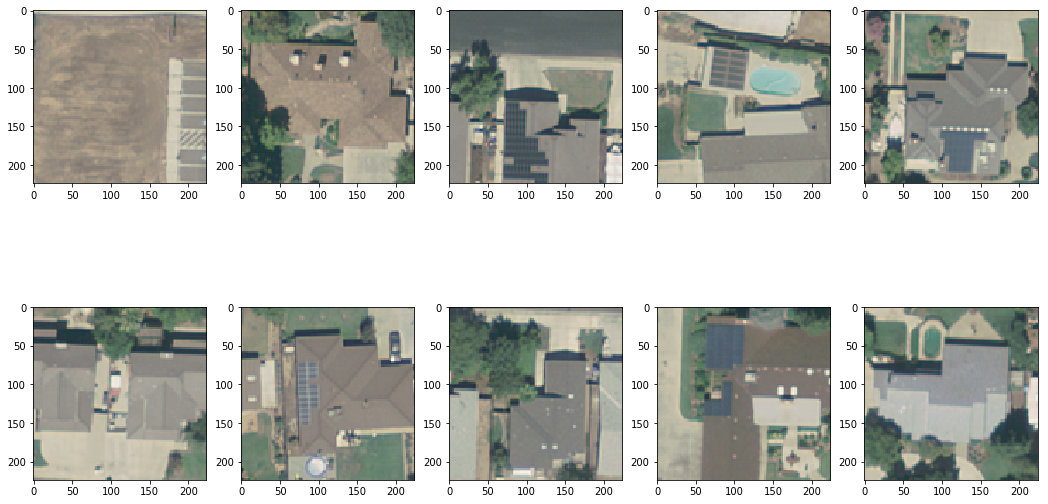

In [38]:
'''
Sample script for cross validated performance
'''
# load the data for knn or random forest, and conduct modeling. Don't do this if you just want to
# conduct cnn modeling.

KNN_or_RF = True # Switch this to True when you're ready to create a submission for Kaggle

if KNN_or_RF:
    num_training_folds = 20

    # Load the data
    data_normal, labels_normal = load_data(dir_train_images, dir_train_labels, training=True)
    plt.figure(figsize = (18,10))
    for i in range(10):
        plt.subplot(2,5,i+1)
        plt.imshow(data[i])
    plt.show()

    # Choose which classifier to use
    # Perform cross validated performance assessment
#     max_auc, best = 0.5, 0
#     for estimator in range(50,1000,50):
#         clf = set_classifier_rf(estimator)
#         prediction_scores = cv_performance_assessment(data_normal,labels_normal,num_training_folds,clf)
#         auc = metrics.roc_auc_score(labels_normal, prediction_scores)
#         if auc > max_auc:
#             best = estimator
#             max_auc = auc
#     print(best)

In [39]:
if KNN_or_RF:
    clf = set_classifier_rf(400)
    prediction_scores_normal = cv_performance_assessment(data_normal,labels_normal,num_training_folds,clf)
    # Compute and plot the ROC curves

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      |

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 400 out of 400 | elapsed:    0.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend 

/Users/kathryncoulter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


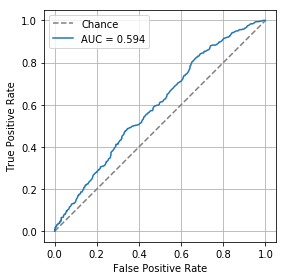

In [40]:
if KNN_or_RF:
    plot_roc(labels_normal, prediction_scores_normal)

In [11]:
# Below is the cnn modeling process
data, labels = load_data_cnn(dir_train_images, dir_train_labels, training=True)

In [12]:
print('data', data.shape)

data (1500, 224, 224, 3)


In [13]:
# Set up training set and validation set
val_split_num = int(round(0.2*len(labels)))
x_train = data[val_split_num:]
y_train = labels[val_split_num:]
x_test = data[:val_split_num]
y_test = labels[:val_split_num]

print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_test', x_test.shape)
print('y_test', y_test.shape)

x_train (1200, 224, 224, 3)
y_train (1200,)
x_test (300, 224, 224, 3)
y_test (300,)


In [14]:
# data preprocessing
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [15]:
# use Keras pre-trained VGG16
add_model = Sequential()
# add layers
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(256, activation='relu'))
add_model.add(Dense(1, activation='sigmoid'))
# add layers to the model
model = Model(inputs=base_model.input, outputs=add_model(base_model.output))
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
# look at the model we got
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [16]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
# set the parameters
batch_size = 32
epochs = 40
# train the cnn model. It takes about 15 min per epochs to train the it.
train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(x_train)

# conduct cross validation and print out the process details to following the process
history = model.fit_generator(
    train_datagen.flow(x_train, y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
    callbacks=[ModelCheckpoint('VGG16-transferlearning.model', monitor='val_acc', save_best_only=True)]
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
37/37 [==============================] - 3826s 103s/step - loss: 0.6390 - acc: 0.6461 - val_loss: 0.5838 - val_acc: 0.7000
Epoch 2/40
37/37 [==============================] - 3796s 103s/step - loss: 0.5538 - acc: 0.7264 - val_loss: 0.5484 - val_acc: 0.7000
Epoch 3/40
37/37 [==============================] - 3683s 100s/step - loss: 0.4877 - acc: 0.7669 - val_loss: 0.4583 - val_acc: 0.8067
Epoch 4/40
37/37 [==============================] - 3775s 102s/step - loss: 0.4389 - acc: 0.8023 - val_loss: 0.4000 - val_acc: 0.8300
Epoch 5/40
37/37 [==============================] - 3781s 102s/step - loss: 0.3980 - acc: 0.8133 - val_loss: 0.3579 - val_acc: 0.8433
Epoch 6/40
37/37 [==============================] - 3966s 107s/step - loss: 0.3680 - acc: 0.8311 - val_loss: 0.3238 - val_acc: 0.8700
Epoch 7/40
37/37 [==============================] - 3860s 104s/step - loss: 0.3215 - acc: 0.8631 - val_loss: 0.4855 - val_acc: 0.7733
Epoch 8/40
37/

/Users/kathryncoulter/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


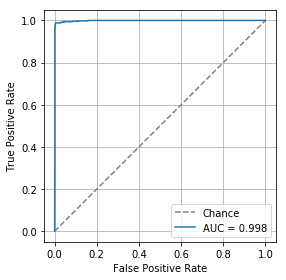

In [26]:
# Plot the roc curve to evaluate the result
data = data.astype('float32')
data /= 255
prediction_scores = model.predict(data).ravel()
plot_roc(labels, prediction_scores)

In [17]:
'''
Sample script for producing a Kaggle submission
'''

produce_submission_cnn = True # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission_cnn:
    # Load the test data and test the classifier
    test_data, ids = load_data_cnn(dir_test_images, dir_test_ids, training=False)
    test_data = test_data.astype('float32')
    test_data /= 255
    # print('test_data', test_data.shape)
    predictions = model.predict(test_data)
    test_scores  = [val for sublist in predictions for val in sublist]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission_cnn.csv',
                           columns=['id','score'],
                           index=False)

In [108]:
'''
Sample script for producing a Kaggle submission
'''

produce_submission_other = False # Switch this to True when you're ready to create a submission for Kaggle

if produce_submission_other:
    # Load data, extract features, and train the classifier on the training data
    training_data, training_labels = load_data(dir_train_images, dir_train_labels, training=True)
    training_features              = preprocess_and_extract_features(training_data)
    clf                            = set_classifier_rf(800)
    clf.fit(training_features,training_labels)

    # Load the test data and test the classifier
    test_data, ids = load_data(dir_test_images, dir_test_ids, training=False)
    test_features  = preprocess_and_extract_features(test_data)
    test_scores    = clf.predict_proba(test_features)[:,1]

    # Save the predictions to a CSV file for upload to Kaggle
    submission_file = pd.DataFrame({'id':    ids,
                                   'score':  test_scores})
    submission_file.to_csv('submission_rf.csv',
                           columns=['id','score'],
                           index=False)


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.2s finished
